In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
#from torchsummary import summary

In [4]:
import os
import numpy as np
#import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
from tqdm import tqdm

In [ ]:
# changing the directory 
os.chdir('../artifacts/02_09_2024_13_41_30\data_ingestion/data')

In [5]:
os.getcwd()

'c:\\fwp_final\\Notebook'

In [6]:
data_path=os.getcwd()

Exploring the data or images

In [13]:
# Defining the class name 
class_name = ['Orignal','Fake']

In [18]:
# Creating a function to  get the list of files
def get_list_of_files(dir_name):
    '''
    input - The input directory location
    output - Returns the list the files in the directory
    '''
    files_list = os.listdir(dir_name)
    return files_list

In [19]:
data_path+'/train/'+class_name[0]

'c:\\fwp_final\\Notebook/train/Orignal'

In [20]:
files_list_orignal_train = get_list_of_files(data_path+'/train/'+class_name[0])

In [21]:
files_list_orignal_train

['dunk-high-younger-shoes-hXXfpL.png', 'Real 11.png']

In [22]:
files_list_fake_train = get_list_of_files(data_path+'/train/'+class_name[1])

In [23]:
files_list_fake_train = get_list_of_files(data_path+'/train/'+class_name[1])

In [24]:
files_list_orignal_test = get_list_of_files(data_path+'/test/'+class_name[0])
files_list_fake_test= get_list_of_files(data_path+'/test/'+class_name[1])

In [25]:
files_list_orignal_test

['Real fake.avif', 'Real nike.png']

In [26]:
files_list_fake_test

['abibas fake.jpg', 'fake 11.png']

In [27]:
print("Number of train samples in Orignal category {}".format(len(files_list_orignal_train)))
print("Number of train samples in Fake category {}".format(len(files_list_fake_train)))
print("Number of test samples in Orignal category {}".format(len(files_list_orignal_test)))
print("Number of test samples in Fake category {}".format(len(files_list_fake_test)))

Number of train samples in Orignal category 2
Number of train samples in Fake category 5
Number of test samples in Orignal category 2
Number of test samples in Fake category 2


In [33]:
rand_img_no = np.random.randint(1,len(files_list_orignal_train))

In [34]:
rand_img_no

1

(290, 274, 4)


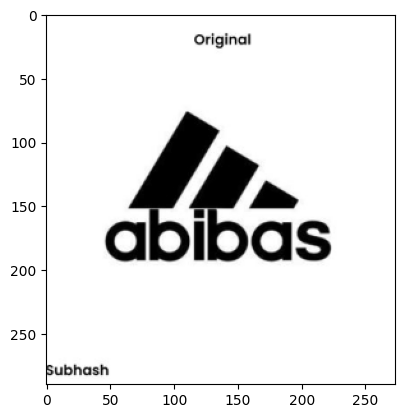

In [35]:
img = data_path + '/train/Orignal/'+ files_list_orignal_train[rand_img_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(1080, 1920, 4)


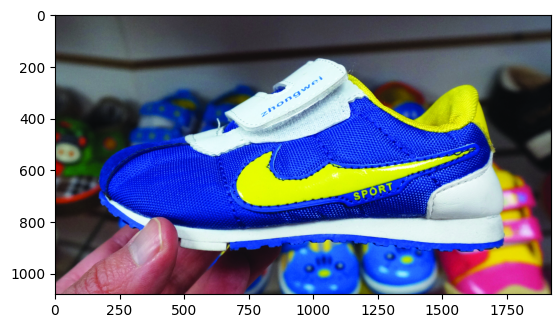

In [36]:
img = data_path + '/train/Fake/'+ files_list_fake_train[np.random.randint(0,len(files_list_fake_train))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [37]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [38]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [39]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)

In [40]:
train_data

Dataset ImageFolder
    Number of datapoints: 7
    Root location: c:\fwp_final\Notebook\train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [41]:
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)

In [42]:
test_data

Dataset ImageFolder
    Number of datapoints: 3
    Root location: c:\fwp_final\Notebook\test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [43]:
train_loader = DataLoader(train_data,
                          batch_size= 2, shuffle= True, pin_memory= True)

In [44]:
test_loader = DataLoader(test_data,
                         batch_size= 2, shuffle= False, pin_memory= True)

In [45]:
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['Fake', 'Orignal']
Number of train images: 7
Number of test images: 3


In [46]:
class Net(nn.Module):
    def __init__(self):
        """
        Creating custom CNN architecture for Image classification
        """
        super(Net, self).__init__()
        # Input Block
        self.convolution_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
                      padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pooling11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 1
        self.convolution_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=20, kernel_size=(3, 3),
                      padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.pooling22 = nn.MaxPool2d(2, 2)
        self.convolution_block3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.pooling33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 2
        self.convolution_block4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.convolution_block5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding='same', bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(10),
#         )
        self.convolution_block6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding='same', bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(32)
#         )
        self.convolution_block7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convolution_block8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )
        self.convolution_block9 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convolution_block_out = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=True),
        )
    def forward(self, x):
        x = self.convolution_block1(x)
        x = self.pooling11(x)
        x = self.convolution_block2(x)
        x = self.pooling22(x)
        x = self.convolution_block3(x)
        x = self.pooling33(x)
        x = self.convolution_block4(x)
        x = self.convolution_block5(x)
#         x = self.convblock6(x)
        x = self.convolution_block6(x)
#         x = self.convblock8(x)
        x = self.convolution_block7(x)
        x = self.convolution_block8(x)
        x = self.convolution_block9(x)
        x = self.gap(x)
        x = self.convolution_block_out(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [48]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
# To check the model summary
#summary(model, input_size=(3, 224, 224))

Available processor cpu


In [49]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [50]:
def train(model, device, train_loader, optimizer, epoch):
    """
    Description: To train the model 
    
    input: model,device,train_loader,optimizer,epoch 
    
    output: loss, batch id and accuracy
    """
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN
        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

In [51]:
def test(model, device, test_loader):
    """
    Description: To test the model
    
    input: model, device, test_loader
    
    output: average loss and accuracy
    
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [52]:
# Defining the params for training 
model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 1

In [53]:
#Training the model
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.5727802515029907 Batch_id=3 Accuracy=57.14: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


current Learning Rate:  0.01

Test set: Average loss: 0.6799, Accuracy: 2/3 (66.67%)



Text(0.5, 1.0, 'Test Accuracy')

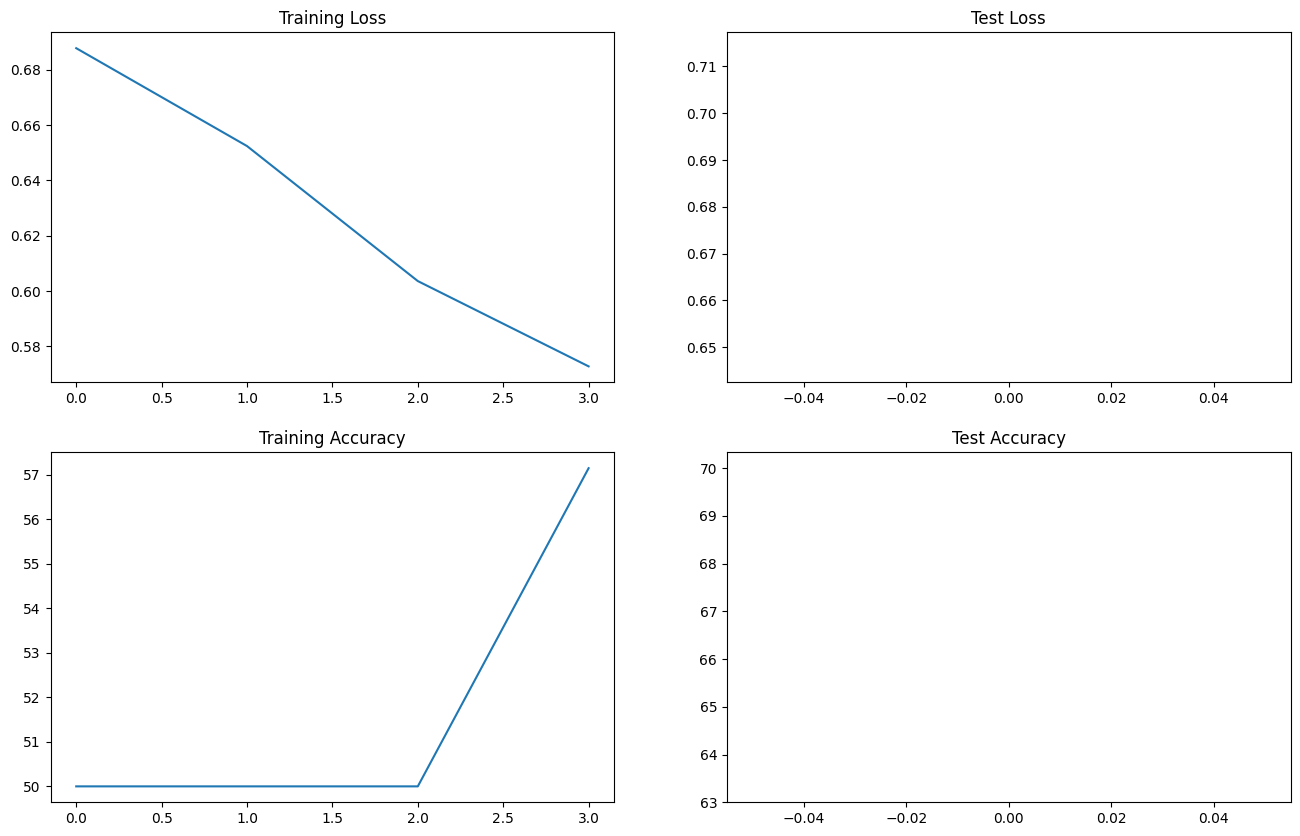

In [54]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")